In [2]:
! pip install pyproj
import pyproj
from pyproj import Proj, transform


ERROR: Could not find a version that satisfies the requirement pyproj (from versions: none)
ERROR: No matching distribution found for pyproj


ModuleNotFoundError: No module named 'pyproj'

In [12]:
# source from https://spatialreference.org
wgs84=Proj("EPSG:4326") # WGS84
utm32_50N=Proj("EPSG:32650") # EPSG:32650: WGS 84 / UTM zone 50N
web_mercator=Proj("EPSG:3857") # EPSG:3857 -- WGS84 Web Mercator (Auxiliary Sphere)

project = lambda x, y: transform(wgs84, utm32_50N, x, y)
inverse = lambda x, y: transform(utm32_50N, wgs84, x, y)
project_webM = lambda x, y: transform(wgs84, web_mercator, x, y)
# proj = pyproj.Proj(proj='utm', zone=50, ellps='WGS84')

In [13]:
project(39.904202,116.407394)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  


(449344.55007802474, 4417292.719846551)

In [14]:
project(39.804202,116.507394)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  


(457831.3533249302, 4406141.971308204)

In [109]:
def create_data_frame(npyfile, pos_webm = None, pos_GPS = None, dummy_array = None, segmentation = False, seq_cutoff_time = 300, seq_cutoff_speed = 42, Standardize = False):

    df = pd.DataFrame(npyfile, columns=["user","lat","lon","alt",'ts', "label"]).astype({'user':'int64', 'lon':'float64','lat':'float64', 'alt':'float64', 'ts':'int64', 'label':'int64'})
    df['ts'] = pd.to_datetime(df['ts'], unit='s')
    df = df.sort_values(by = ["ts"])
    assert df['ts'].is_monotonic_increasing == True

    mask_50 = (df['lon'] > 114.0) & (df['lon'] < 120.0) & (df['lat'] > 32.0) & (df['lat'] < 48.0)
    # mask_50 = (df['lon'] >= 116.25) & (df['lon'] < 116.5) & (df['lat'] > 39.8) & (df['lat'] < 40.1)
    df = df[mask_50]

    # x, y = proj(df['lon'].tolist(), df['lat'].tolist())
    x, y = project(df.lat, df.lon)
    df = pd.concat([df, pd.DataFrame(np.c_[x,y], columns=["x","y"])], axis=1)

    if dummy_array is not None:
        
        df['f_highway_motorway'] = dummy_array[:,0]
        df['f_traffic_signals'] = dummy_array[:,1]
        df['f_bus_stops'] = dummy_array[:,2]
        df['f_landuse_meadow'] = dummy_array[:,3]
        df['f_landuse_residential'] = dummy_array[:,4]
        df['f_landuse_industrial'] = dummy_array[:,5]
        df['f_landuse_commercial'] = dummy_array[:,6]
        df['f_shop'] = dummy_array[:,7]
        df['f_railways'] = dummy_array[:,8]
        df['f_railways_station'] = dummy_array[:,9]
        df['f_subway'] = dummy_array[:,10]
        
    if pos_webm is not None:
        df['x_web'] = pos_webm[:, 0]
        df['y_web'] = pos_webm[:, 1]
        
    if pos_GPS is not None:
        df['lon'] = pos_GPS[:, 0]
        df['lat']= pos_GPS[:, 1]
        
    df.sort_values('ts', inplace = True)
    
    df['delta_t'] = np.concatenate([[0], (df['ts'].values[1:] - df['ts'].values[:-1]) / pd.to_timedelta('1s')], axis = 0)    
    df['delta_d'] = np.concatenate([[0], np.linalg.norm(df[['x', 'y']].values[1:] - df[['x', 'y']].values[:-1], axis = 1)], axis = 0)    
    df['bearing'] = np.concatenate([[0], np.arctan2(df[['y']].values[1:] - df[['y']].values[:-1], df[['x']].values[1:] - df[['x']].values[:-1]).reshape(-1)], axis = 0)
    df['speed'] = df['delta_d'] / df['delta_t'] 
    
    cut_labels_6 = [0, 1, 2, 3, 4]
    cut_bins = [0, 6, 10, 14, 18, 24]
    df['tod'] = pd.cut(df['ts'].dt.hour, bins=cut_bins, labels=cut_labels_6, right = False).cat.codes
    
    df = df[lambda x: x['delta_t'] > 0].copy()
    
    seq_bins = np.cumsum((df['delta_t'] >= seq_cutoff_time) | (df['speed'] > seq_cutoff_speed))
    seq_bin_ids, seq_bin_counts = np.unique(seq_bins, return_counts=True)
    
    if segmentation:
        df['segment_id'] = seq_bins
        df['segment_ix'] = np.concatenate([np.arange(seq_bin_counts[i]) for i in range(len(seq_bin_counts))])
        df['segment_point_count'] = np.repeat(seq_bin_counts, seq_bin_counts)
    
    if Standardize:
        df = scale_by_ID(df, ['delta_d','bearing','speed'])
    
    return df


In [11]:
import os
working_path = 'C:/Users/losdwind/Google 云端硬盘/s182190/data'
os.chdir(f'{working_path}')

import pandas as pd
import numpy as np
from src.data_utils_conda import train_test_data_split

In [12]:
test_df = create_data_frame(np.load(f'{working_path}/Geolife/numpyL/user/labelled_user_3.npy'), segmentation=True, seq_cutoff_time = 200, seq_cutoff_speed = 60)

NameError: name 'create_data_frame' is not defined

In [111]:
test_df.head()

,user,lat,lon,alt,ts,label,x,y,delta_t,delta_d,bearing,speed,tod,segment_id,segment_ix,segment_point_count
5879,3.0,40.051901,116.404822,151.0,2008-07-30 12:36:10,2.0,442583.338881,4.429173e+06,2.0,56.107532,-0.855248,28.053766,2,0,0,190
5880,3.0,40.051854,116.404796,169.0,2008-07-30 12:36:12,2.0,442620.486458,4.429131e+06,2.0,56.583241,-0.854611,28.291620,2,0,1,190
5881,3.0,40.051852,116.404727,188.0,2008-07-30 12:36:14,2.0,442656.525764,4.429088e+06,2.0,55.770617,-0.868194,27.885309,2,0,2,190
5882,3.0,40.051854,116.404713,188.0,2008-07-30 12:36:16,2.0,442692.068439,4.429047e+06,2.0,53.929680,-0.851234,26.964840,2,0,3,190
5883,3.0,40.051855,116.404691,188.0,2008-07-30 12:36:18,2.0,442726.322900,4.429006e+06,2.0,53.934663,-0.882645,26.967332,2,0,4,190


In [112]:
test_df.tod.dtype

dtype('int8')

In [113]:
seq_cutoff_speed = 45
seq_cutoff_time = 60
filter_seq = 5
files = []
for _,_,filenames in os.walk(f'{working_path}/Geolife/numpyL/user/'):
    files = filenames
    print(files)
dataset_geolife = pd.concat([create_data_frame(np.load(f'{working_path}/Geolife/numpyL/user/{name}'), segmentation=True, seq_cutoff_time = seq_cutoff_time, seq_cutoff_speed = seq_cutoff_speed) for name in files]).reset_index(drop=True)
pd.to_pickle(dataset_geolife, "./Geolife/dataset_geolife.pkl")

['labelled_user_10.npy', 'labelled_user_15.npy', 'labelled_user_13.npy', 'labelled_user_14.npy', 'labelled_user_12.npy', 'labelled_user_1.npy', 'labelled_user_16.npy', 'labelled_user_2.npy', 'labelled_user_18.npy', 'labelled_user_19.npy', 'labelled_user_20.npy', 'labelled_user_11.npy', 'labelled_user_22.npy', 'labelled_user_17.npy', 'labelled_user_24.npy', 'labelled_user_23.npy', 'labelled_user_27.npy', 'labelled_user_26.npy', 'labelled_user_34.npy', 'labelled_user_25.npy', 'labelled_user_29.npy', 'labelled_user_35.npy', 'labelled_user_30.npy', 'labelled_user_36.npy', 'labelled_user_21.npy', 'labelled_user_37.npy', 'labelled_user_38.npy', 'labelled_user_47.npy', 'labelled_user_44.npy', 'labelled_user_42.npy', 'labelled_user_39.npy', 'labelled_user_50.npy', 'labelled_user_46.npy', 'labelled_user_43.npy', 'labelled_user_3.npy', 'labelled_user_53.npy', 'labelled_user_56.npy', 'labelled_user_58.npy', 'labelled_user_9.npy', 'labelled_user_68.npy', 'labelled_user_59.npy', 'labelled_user_66.n

In [114]:
dataset_geolife['user'].unique()

array([10., 15., 13., 14., 12.,  1., 16.,  2., 18., 19., 20., 11., 22.,
       17., 24., 23., 27., 26., 34., 25., 29., 35., 30., 36., 21., 37.,
       38., 47., 44., 42., 39., 50., 46., 43.,  3., 53., 56., 58.,  9.,
       68., 59., 66., 60., 67.,  6., 31., 32., 33.,  4., 40., 41., 45.,
       48., 49.,  5., 51., 54., 55., 57., 61., 62., 63., 69.,  8.])

In [115]:
dataset_geolife[dataset_geolife['user'] == 2].head()

,user,lat,lon,alt,ts,label,x,y,delta_t,delta_d,bearing,speed,tod,segment_id,segment_ix,segment_point_count
140289,2.0,39.981267,116.328317,203.412073,2007-08-18 02:44:00,2.0,442626.452809,4.425680e+06,1063.0,63.041523,-1.510556,0.059305,0,1,0,5
140290,2.0,39.981600,116.329550,203.412073,2007-08-18 02:44:11,2.0,442652.864887,4.425596e+06,11.0,87.527206,-1.264260,7.957019,0,1,1,5
140291,2.0,39.982100,116.329583,203.412073,2007-08-18 02:44:55,2.0,442660.734971,4.425507e+06,44.0,89.205069,-1.482457,2.027388,0,1,2,5
140292,2.0,39.981917,116.328850,203.412073,2007-08-18 02:45:34,2.0,442665.953953,4.425444e+06,39.0,63.153857,-1.488063,1.619330,0,1,3,5
140293,2.0,39.982283,116.328533,203.412073,2007-08-18 02:46:15,2.0,442780.992922,4.425412e+06,41.0,119.491410,-0.273844,2.914425,0,1,4,5


# Data loader

## Load Data

In [1]:
import os
working_path ='C:/Users/losdwind/Google 云端硬盘/s182190/data'

os.chdir(f'{working_path}')

import pandas as pd
import numpy as np
from src.data_utils_conda import train_test_data_split

### Load GPS+GIS fusion tensors - dimensionality 9x9x11 - ( [see explaination here](https://www.sciencedirect.com/science/article/pii/S0968090X20307385?dgcid=author#bfn4))

Remember to delete "image_data" after training, before loading "image_data" with the user_test partition, so that the dataloader can perform the test on your network, with weights and biases resulting from the training.

In [2]:
dataset = pd.read_pickle(f'{working_path}/Geolife/dataset_geolife.pkl')

In [3]:
dataset.head(50)

,user,lat,lon,alt,ts,label,x,y,delta_t,delta_d,bearing,speed,tod,segment_id,segment_ix,segment_point_count
0,10.0,39.972817,116.327400,206.692913,2007-10-10 13:24:26,4.0,441948.174613,4.424823e+06,30.0,34.359226,-0.115514,1.145308,2,0,0,6
1,10.0,39.972400,116.327350,232.939633,2007-10-10 13:24:45,4.0,441929.855475,4.424847e+06,19.0,30.343109,2.218972,1.597006,2,0,1,6
2,10.0,39.972200,116.327383,259.186352,2007-10-10 13:24:53,4.0,441918.455249,4.424845e+06,8.0,11.535745,-2.988160,1.441968,2,0,2,6
3,10.0,39.971950,116.327417,278.871391,2007-10-10 13:25:05,4.0,441867.260063,4.424851e+06,12.0,51.538688,3.026073,4.294891,2,0,3,6
4,10.0,39.971583,116.327417,246.062992,2007-10-10 13:25:23,4.0,441829.584698,4.425136e+06,18.0,287.659306,1.702146,15.981073,2,0,4,6
5,10.0,39.970917,116.327483,206.692913,2007-10-10 13:25:53,4.0,441886.682534,4.425158e+06,30.0,61.104960,0.364163,2.036832,2,0,5,6
6,10.0,39.968550,116.327700,164.041995,2007-10-10 13:27:42,4.0,441908.242308,4.425186e+06,109.0,35.010718,0.907389,0.321199,2,1,0,15
7,10.0,39.968050,116.327717,160.761155,2007-10-10 13:28:08,4.0,441948.063747,4.425182e+06,26.0,40.022191,-0.100202,1.539315,2,1,1,15
8,10.0,39.967517,116.327733,167.322835,2007-10-10 13:28:34,4.0,442016.616903,4.425212e+06,26.0,75.206486,0.423801,2.892557,2,1,2,15
9,10.0,39.967317,116.327717,164.041995,2007-10-10 13:28:44,4.0,442109.138722,4.425214e+06,10.0,92.528917,0.012386,9.252892,2,1,3,15


In [4]:
dataset.isnull().any()

user                   False
lat                    False
lon                    False
alt                    False
ts                     False
label                  False
x                       True
y                       True
delta_t                False
delta_d                 True
bearing                 True
speed                   True
tod                    False
segment_id             False
segment_ix             False
segment_point_count    False
dtype: bool

In [5]:
dataset.isnull().sum()

user                        0
lat                         0
lon                         0
alt                         0
ts                          0
label                       0
x                      274489
y                      274489
delta_t                     0
delta_d                274739
bearing                274739
speed                  274739
tod                         0
segment_id                  0
segment_ix                  0
segment_point_count         0
dtype: int64

In [6]:
len(dataset)

4324584

In [7]:
dataset = dataset.dropna()

In [8]:
dataset.isnull().sum()

user                   0
lat                    0
lon                    0
alt                    0
ts                     0
label                  0
x                      0
y                      0
delta_t                0
delta_d                0
bearing                0
speed                  0
tod                    0
segment_id             0
segment_ix             0
segment_point_count    0
dtype: int64

In [9]:
dataset.ts[1]- dataset.ts[0]

Timedelta('0 days 00:00:19')

<AxesSubplot:>

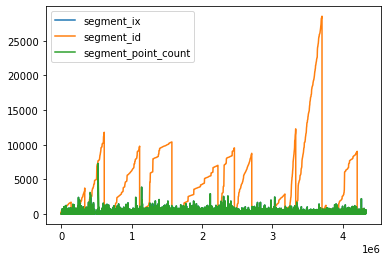

In [10]:
#%%script false
dataset[['segment_ix','segment_id', 'segment_point_count' ]].plot()

In [11]:
%%script false
dataset[['segment_id', 'segment_ix', 'segment_point_count' ]].plot()

Couldn't find program: 'false'


In [12]:
%%script false
dataset[['segment_ix', 'segment_point_count' ]].plot()

Couldn't find program: 'false'


In [13]:
%%script false
dataset[['segment_point_count' ]].plot.kde()

Couldn't find program: 'false'


In [14]:
dataset['label'].unique()

array([  4.,   3.,   2.,   0.,   1., 100.])

In [15]:
dataset[dataset['user'] == 2].head()

,user,lat,lon,alt,ts,label,x,y,delta_t,delta_d,bearing,speed,tod,segment_id,segment_ix,segment_point_count
140289,2.0,39.981267,116.328317,203.412073,2007-08-18 02:44:00,2.0,442626.452809,4.425680e+06,1063.0,63.041523,-1.510556,0.059305,0,1,0,5
140290,2.0,39.981600,116.329550,203.412073,2007-08-18 02:44:11,2.0,442652.864887,4.425596e+06,11.0,87.527206,-1.264260,7.957019,0,1,1,5
140291,2.0,39.982100,116.329583,203.412073,2007-08-18 02:44:55,2.0,442660.734971,4.425507e+06,44.0,89.205069,-1.482457,2.027388,0,1,2,5
140292,2.0,39.981917,116.328850,203.412073,2007-08-18 02:45:34,2.0,442665.953953,4.425444e+06,39.0,63.153857,-1.488063,1.619330,0,1,3,5
140293,2.0,39.982283,116.328533,203.412073,2007-08-18 02:46:15,2.0,442780.992922,4.425412e+06,41.0,119.491410,-0.273844,2.914425,0,1,4,5


In [16]:
# rename mode 100 to mode 5
dataset['label'][dataset['label'] ==100] = 5

In [17]:
dataset = dataset[['user','label','bearing','speed','tod', 'delta_d','segment_ix']]

In [18]:
dataset.head()

,user,label,bearing,speed,tod,delta_d,segment_ix
0,10.0,4.0,-0.115514,1.145308,2,34.359226,0
1,10.0,4.0,2.218972,1.597006,2,30.343109,1
2,10.0,4.0,-2.988160,1.441968,2,11.535745,2
3,10.0,4.0,3.026073,4.294891,2,51.538688,3
4,10.0,4.0,1.702146,15.981073,2,287.659306,4


## Create train validation and test partitions

Since user 4 and 9 have lots of points, We use k parameter to define a specific slice of the train, validation and test collection. If you want to learn more, please go to the data utilis.py. 

For the formal test later of the algorithm, the -random- parameter is set to be True, k is not invoked.

In [19]:
from sklearn.model_selection import train_test_split
#x_sub, user_test = train_test_split(dataset.user.unique()[1:30],test_size=0.2,train_size=0.8)
#user_train, user_val= train_test_split(x_sub,test_size = 0.25,train_size =0.75)



user_train = [12, 20, 42, 14, 11, 19, 16, 27,  2, 26, 29, 37, 21, 22, 47, 18,  1,]
user_val = [23, 38, 15, 25, 34, 17,]
user_test =  [13, 35, 24, 36, 44, 30,]

# user_train, user_val, user_test = train, val, test = train_test_data_split(dataset.user.unique(),Random=True) # use specified splits, check the source code
print(f'partition: train {user_train}, validation {user_val}, test {user_test}')

data_train =  pd.concat([dataset[(dataset.user==tr)] for tr in user_train]).reset_index(drop=True)
data_val = pd.concat([dataset[(dataset.user==va)] for va in user_val]).reset_index(drop=True)
data_test = pd.concat([dataset[(dataset.user==te)] for te in user_test]).reset_index(drop=True)

print(f'length: train {len(data_train)}, validation {len(data_val)}, test {len(data_test)}')

data_train.head(50)

partition: train [12, 20, 42, 14, 11, 19, 16, 27, 2, 26, 29, 37, 21, 22, 47, 18, 1], validation [23, 38, 15, 25, 34, 17], test [13, 35, 24, 36, 44, 30]
length: train 367809, validation 100863, test 19346


,user,label,bearing,speed,tod,delta_d,segment_ix
0,12.0,2.0,-2.318374,4.295296,0,120.268293,0
1,12.0,2.0,3.134240,0.679926,0,61.193363,0
2,12.0,2.0,2.872733,0.736592,0,50.088252,0
3,12.0,2.0,1.368683,0.799308,0,73.536348,0
4,12.0,2.0,1.852856,0.251410,0,59.835609,0
5,12.0,2.0,1.641768,0.673512,0,90.924091,0
6,12.0,2.0,-3.092502,0.541861,0,65.565162,0
7,12.0,2.0,-2.740076,0.647851,0,51.180226,0
8,12.0,2.0,3.036043,0.612834,0,94.376444,0
9,12.0,2.0,-3.067923,1.328141,0,114.220105,0


### Define Image Tensor Dataloader

We implement our own Tensor Dataset in order to be able to do fast lookup of sequences and images. Just add features inside
```
df[['feat1','feat2',...]]
```

In [20]:
import torch
filter_seq = 6
class ImageTensorDataset(torch.utils.data.Dataset):
    def __init__(self, df ,filter_seq=filter_seq):
        self.seq = np.stack([np.roll(df[['delta_d', 'bearing','speed']].values, i, axis = 0) for i in range(filter_seq-1, -1, -1)], axis = 1)
        self.seq = self.seq[df['segment_ix'] >= filter_seq]


        self.label = df[df['segment_ix'] >= filter_seq]['label'].values
     
        self.user_id = df[df['segment_ix'] >= filter_seq]['user'].values

        tod = df[df['segment_ix'] >= filter_seq]['tod'].values
        self.tod_one_hot = np.eye(5)[tod]
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, key):

        return self.seq[key], self.tod_one_hot[key], self.label[key]

demo_dataset = ImageTensorDataset(data_train)
demo_loader = torch.utils.data.DataLoader(demo_dataset, batch_size=13500, shuffle=True)

for X_seq, X_tod, y in demo_loader:

    print('X_seq :', X_seq.shape)
    print(X_seq[0, :])
    print('X_tod :', X_tod.shape)
    print(X_tod[0])
    print('y:', y.shape)
    print(y[0])
    break;

X_seq : torch.Size([13500, 6, 3])
tensor([[ 0.0854,  3.1341,  0.0171],
        [ 0.1110,  1.5633,  0.0222],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0854, -0.0075,  0.0427],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]], dtype=torch.float64)
X_tod : torch.Size([13500, 5])
tensor([0., 0., 0., 0., 1.], dtype=torch.float64)
y: torch.Size([13500])
tensor(2., dtype=torch.float64)


In [21]:
len(demo_loader)

24

### define train, val, test set and dataloader

In [22]:
    train_dataset = ImageTensorDataset(data_train)
    val_dataset = ImageTensorDataset(data_val)
    test_dataset = ImageTensorDataset(data_test)

In [23]:
train_dataset[2]

(array([[6.91090227, 2.57046468, 1.38218045],
        [9.2875579 , 2.3914295 , 1.85751158],
        [5.81852812, 2.16232244, 1.16370562],
        [9.4138089 , 2.37696808, 1.88276178],
        [7.70494533, 1.20586735, 1.54098907],
        [6.66521604, 2.2882858 , 1.33304321]]),
 array([0., 0., 0., 0., 1.]),
 2.0)

In [24]:
np.unique(dataset['label'])

array([0., 1., 2., 3., 4., 5.])

In [25]:
train_dataset.label

array([2., 2., 2., ..., 0., 0., 0.])

In [26]:
np.unique(train_dataset.label)

array([0., 1., 2., 3., 4., 5.])

In [27]:
np.unique(val_dataset.label)

array([0., 1., 2., 3., 4., 5.])

In [28]:
np.unique(test_dataset.label)

array([0., 1., 2., 3., 4.])

# Model CNN_RNN_GIS_Multi_Targets
If we want to classify not only stop/move status, but also trip purpose and travel mode. In this case, stop/move has two status, trip purpose has 16 status, and travel mode has 9 status. So, in total, it is 27 status. We try to modify the last layer of fully connected network to be 27 neurons and when doing loss computation, the target is also split into three catagory, each catagory has its own loss, with finnaly three loss combined into One total loss.

In [142]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from collections import OrderedDict
torch.manual_seed(1) # 设置随机种子，保证可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 设置使用CPU or GPU

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.metrics import recall_score,precision_score,f1_score

from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

## Network

In [143]:
# use to select the output of RNN out from the tuple in nn.sequential
class SelectItem(nn.Module):
    def __init__(self, item_index):
        super(SelectItem, self).__init__()
        self._name = 'selectitem'
        self.item_index = item_index

    def forward(self, inputs):
        
        return inputs[self.item_index]


# how to init weights in pytorch: https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
def init_weights(m):
    if type(m) == nn.GRU:
    #     for weight in m.parameters():
    #         torch.nn.init.orthogonal_(weight)
    #     # torch.nn.init.xavier_uniform(m.weight)
        # m.bias.data.fill_(0.01)

        # lstm
        #  for name, param in self.lstm.named_parameters():
        #     if 'bias' in name:
        #          nn.init.constant_(param, 0.0)
        #     elif 'weight_ih' in name:
        #          nn.init.kaiming_normal_(param)
        #     elif 'weight_hh' in name:
        #          nn.init.orthogonal_(param)

        # Gru
        for name, param in m.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

class Net_CNN_RNN_GIS_Multi_Purpose(nn.Module):
    def __init__(self):
        super(Net_CNN_RNN_GIS_Multi_Purpose, self).__init__()


        self.rnn = nn.Sequential(OrderedDict([
                                              ('bi-gru1', nn.GRU(input_size = 3, hidden_size = 32, num_layers = 2, batch_first = True, bidirectional = True)),
                                              ('drop_h0', SelectItem(0)),
                                            #   ('bi-gru2', nn.GRU(input_size = 10, hidden_size = 5, num_layers = 2, batch_first = True, bidirectional = True)),
                                            #   ('drop_h1', SelectItem(0)),
                                            #   ('norm1', nn.BatchNorm1d(num_features = 6)),
                                              ('relu1', nn.ReLU(inplace=True)),
                                              ('drop1', nn.Dropout(p = 0.2)),

        ]))

        self.fc = nn.Sequential(OrderedDict([
                                             ('fc1', nn.Linear(in_features = filter_seq * 2 * 32 + 5, out_features = 512)),
                                             ('relu1', nn.ReLU(inplace=True)),
                                             ('fc2', nn.Linear(in_features = 512, out_features = 100)),
                                             ('relu2', nn.ReLU(inplace=True)),
                                             ('fc3', nn.Linear(in_features = 100, out_features = 6 )),
                                             
        ]))

    def forward(self, X_seq, X_tod):

        x2 = self.rnn(X_seq)
        x2 = torch.flatten(x2, start_dim= 1)
        x3 = torch.cat((x2, X_tod), dim = 1)
        x4 = self.fc(x3)
        
        return x4


In [144]:
import numpy as np
net = Net_CNN_RNN_GIS_Multi_Purpose()
net.apply(init_weights)
np.sum([np.product(x.detach().cpu().numpy().shape) for x in net.parameters()])

277506

## Main

discuss about the observations which 

In [145]:
unique, counts = np.unique(data_train['label'], return_counts=True)
print(f'labelM: {unique},{counts}')
weightLabelM = torch.DoubleTensor(1/counts * np.min(counts))
print(weightLabelM)


labelM: [0. 1. 2. 3. 4. 5.],[ 91576 111556 117396  40340   6613    328]
tensor([0.0036, 0.0029, 0.0028, 0.0081, 0.0496, 1.0000], dtype=torch.float64)


In [146]:
mode_names = ["0", "1","2","3","4","100"]

In [147]:

# from getpass import getpass
# api_token = getpass('Enter your private Neptune API token: ')
api_token = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiN2ZhOTE4MDEtMWQxOC00NDU2LThiZGYtNTQ3NjAxMWJkOGUyIn0='

In [148]:
# eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiN2ZhOTE4MDEtMWQxOC00NDU2LThiZGYtNTQ3NjAxMWJkOGUyIn0=

In [149]:
# Setup Neptune#
!pip install neptune-client
import neptune
neptune.init(project_qualified_name = 'losdwind/s182190',
             api_token = api_token)


Project(losdwind/s182190)

In [150]:
# use SWAG
#!pip install torchcontrib
#from torchcontrib.optim import SWA     # use SWA#G
! pip install scikit-plot
import matplotlib.pyplot as plt
import scikitplot as skplt
import sklearn
import hashlib

# Import l#og_table
! pip install neptune-contrib
from neptunecontrib.api.table import log_table

In [151]:
def plot_roc(y_true, y_probas, title='ROC Curves',
                   plot_micro=True, plot_macro=True, classes_to_plot=None,
                   ax=None, figsize=None, cmap='nipy_spectral',
                   title_fontsize="large", text_fontsize="medium"):
    """Generates the ROC curves from labels and predicted scores/probabilities
    Args:
        y_true (array-like, shape (n_samples)):
            Ground truth (correct) target values.
        y_probas (array-like, shape (n_samples, n_classes)):
            Prediction probabilities for each class returned by a classifier.
        title (string, optional): Title of the generated plot. Defaults to
            "ROC Curves".
        plot_micro (boolean, optional): Plot the micro average ROC curve.
            Defaults to ``True``.
        plot_macro (boolean, optional): Plot the macro average ROC curve.
            Defaults to ``True``.
        classes_to_plot (list-like, optional): Classes for which the ROC
            curve should be plotted. e.g. [0, 'cold']. If given class does not exist,
            it will be ignored. If ``None``, all classes will be plotted. Defaults to
            ``None``
        ax (:class:`matplotlib.axes.Axes`, optional): The axes upon which to
            plot the curve. If None, the plot is drawn on a new set of axes.
        figsize (2-tuple, optional): Tuple denoting figure size of the plot
            e.g. (6, 6). Defaults to ``None``.
        cmap (string or :class:`matplotlib.colors.Colormap` instance, optional):
            Colormap used for plotting the projection. View Matplotlib Colormap
            documentation for available options.
            https://matplotlib.org/users/colormaps.html
        title_fontsize (string or int, optional): Matplotlib-style fontsizes.
            Use e.g. "small", "medium", "large" or integer-values. Defaults to
            "large".
        text_fontsize (string or int, optional): Matplotlib-style fontsizes.
            Use e.g. "small", "medium", "large" or integer-values. Defaults to
            "medium".
    Returns:
        ax (:class:`matplotlib.axes.Axes`): The axes on which the plot was
            drawn.
    Example:
        >>> import scikitplot as skplt
        >>> nb = GaussianNB()
        >>> nb = nb.fit(X_train, y_train)
        >>> y_probas = nb.predict_proba(X_test)
        >>> skplt.metrics.plot_roc(y_test, y_probas)
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe967d64490>
        >>> plt.show()
        .. image:: _static/examples/plot_roc_curve.png
           :align: center
           :alt: ROC Curves
    """
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)

    classes = range(6)
    probas = y_probas

    if classes_to_plot is None:
        classes_to_plot = classes

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.set_title(title, fontsize=title_fontsize)

    fpr_dict = dict()
    tpr_dict = dict()

    indices_to_plot = np.in1d(classes, classes_to_plot)
    for i in classes:
        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true, probas[:, i],
                                                pos_label= classes[i])
        if True:
            roc_auc = auc(fpr_dict[i], tpr_dict[i])
            color = plt.cm.get_cmap(cmap)(float(i) / len(classes))
            ax.plot(fpr_dict[i], tpr_dict[i], lw=2, color=color,
                    label='ROC curve of class {0} (area = {1:0.2f})'
                          ''.format(classes[i], roc_auc))

    if plot_micro:
        binarized_y_true = label_binarize(y_true, classes=classes)
        if len(classes) == 2:
            binarized_y_true = np.hstack(
                (1 - binarized_y_true, binarized_y_true))
        fpr, tpr, _ = roc_curve(binarized_y_true.ravel(), probas.ravel())
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr,
                label='micro-average ROC curve '
                      '(area = {0:0.2f})'.format(roc_auc),
                color='deeppink', linestyle=':', linewidth=4)

    if plot_macro:
        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr_dict[x] for x in range(len(classes))]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(classes)):
            mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])

        # Finally average it and compute AUC
        mean_tpr /= len(classes)
        roc_auc = auc(all_fpr, mean_tpr)

        ax.plot(all_fpr, mean_tpr,
                label='macro-average ROC curve '
                      '(area = {0:0.2f})'.format(roc_auc),
                color='navy', linestyle=':', linewidth=4)

    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=text_fontsize)
    ax.set_ylabel('True Positive Rate', fontsize=text_fontsize)
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc='lower right', fontsize=text_fontsize)

    return ax

In [152]:
def CM_ROC_AUC(y_true, y_predict, y_score):
    pass

In [153]:
def main(train_dataset, val_dataset, test_dataset, PARAMS):

    epochs = PARAMS['epochs']
    batch_size = PARAMS['batch_size']

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= len(test_dataset), shuffle=True)

    model = Net_CNN_RNN_GIS_Multi_Purpose().double().to(device) #
    model.apply(init_weights)
    # base_opt = optim.Adam(model.parameters(), lr= PARAMS['lr'] , weight_decay= PARAMS['weight_decay'])  # infinite weight for class with 
    # optimizer = SWA(base_opt, swa_start=10, swa_freq=5, swa_lr=0.005)
    if PARAMS['Adam'] == True:
        optimizer = optim.Adam(model.parameters(), lr = 0.01, betas = (0.9, 0.999), eps=1e-7, weight_decay=0)
    else:
        optimizer = optim.SGD(model.parameters(), lr =PARAMS['lr'], momentum = PARAMS['momentum'])


    # log params
    neptune.create_experiment(name = 'MMM_Model_Geolife', description = "MMM multi-label model working on the Geolife dataset " , params=PARAMS, tags = ['MMM_Model','Advanced' 'Geolife'])
    
    train_dataset.labelM = train_dataset.label
    val_dataset.labelM = val_dataset.label
    test_dataset.labelM = val_dataset.label

    train_classesM, train_countM = np.unique(train_dataset.labelM, return_counts=True)

    val_classesM, val_countM = np.unique(val_dataset.labelM, return_counts=True)

    test_classesM, test_countM = np.unique(test_dataset.labelM, return_counts=True)


    neptune.log_text("users", f'Train Set Users: {np.unique(train_dataset.user_id)}')
    neptune.log_text("users", f'Val Set Users: {np.unique(val_dataset.user_id)}')
    neptune.log_text("users", f'Test Set Users: {np.unique(test_dataset.user_id)}')
    neptune.log_text("classes and counts", f'train_classes and counts for mode: {train_classesM} \n {train_countM}')

    neptune.log_text("classes and counts", f'val_classes and counts for mode: {val_classesM} \n {val_countM}')

    neptune.log_text("classes and counts", f'test_classes and counts for mode: {test_classesM} \n {test_countM}')



    for epoch in range(1, epochs + 1):
        
        train_loss = 0

        train_targsM = []


        train_predsM = []

        train_preds_probaM = []

        model.train() # 必备，将模型设置为训练模式
        for batch_idx, (X_seq, X_tod, targetM) in enumerate(train_loader): # 从数据加载器迭代一个batch的数据
            X_seq, X_tod,targetM = X_seq.double().to(device), X_tod.double().to(device),targetM.long().to(device) # 将数据存储CPU或者GPU
            optimizer.zero_grad() # 清除所有优化的梯度
            output = model(X_seq, X_tod).double()  # 喂入数据并前向传播获取输出
            criterion1 = nn.CrossEntropyLoss(weight = weightLabelM.to(device)) # This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
            
            ## more experiments to do, weights across mode/purpose
            ## track the loss and find the influence of different modes/purpose on the total loss
            loss = criterion1(output, targetM) # 调用损失函数计算损失
            loss.backward() # 反向传播


            torch.nn.utils.clip_grad_norm_(model.parameters(), PARAMS['clipping'])
            optimizer.step() # 更新参数
            
            train_loss += loss * batch_size  # sum the batch loss  
            predsM = torch.max(output, 1)[1].cpu()


            
            train_targsM += targetM.tolist()
            train_predsM += predsM.tolist()


            if epoch == epochs:
                # save status
                train_preds_probaM += output.tolist()

        
        
        train_accM = accuracy_score(train_targsM, train_predsM)

        
        # log the train loss
        neptune.log_metric('train_loss', x = epoch, y = train_loss/len(train_loader))
        # log the train accuracy
        neptune.log_metric('train_accM', x = epoch, y = train_accM)


        # 必备，将模型设置为评估模式
        model.eval() 
        val_loss = 0
        val_targsM = []
 

        val_predsM = []

        val_preds_probaM = []


        with torch.no_grad(): # 禁用梯度计算
            for batch_idx, (X_seq, X_tod, targetM) in enumerate(val_loader): # 从数据加载器迭代一个batch的数据
                X_seq, X_tod, targetM = X_seq.double().to(device), X_tod.double().to(device),targetM.long().to(device)  # 将数据存储CPU或者GPU
                output = model(X_seq, X_tod).double()  # 喂入数据并前向传播获取输出
                # put weight here???
                criterion1 = nn.CrossEntropyLoss(weight = weightLabelM.to(device))
                loss = criterion1(output, targetM) # 调用损失函数计算损失
                val_loss += loss * batch_size  # sum the batch loss   
                predsM = torch.max(output, 1)[1].cpu()



                val_targsM += targetM.tolist()
                val_predsM += predsM.tolist()


                if epoch == epochs:
                    # save status
                    val_preds_probaM += output.tolist()

            val_accM = accuracy_score(val_targsM, val_predsM)

            

        # log the val loss
        neptune.log_metric('val_loss', x = epoch, y = val_loss/len(val_loader))
        # log the val accuracy
        neptune.log_metric('val_accM', x = epoch, y = val_accM)

        neptune.log_text('process', f'epoch: {epoch}, train_loss: {train_loss}, train_accM: {train_accM}, val_loss: {val_loss}, val_accM: {val_accM}')
        
        if epoch == epochs:
            
            # 1
            CM_train_M = skplt.metrics.plot_confusion_matrix(train_targsM, train_predsM, normalize=True,x_tick_rotation=45, title='Confusion Matrix of Mode Detection on Train set')
            CM_train_M.set_xticklabels(mode_names)
            CM_train_M.set_yticklabels(mode_names)
            CM_train_M = CM_train_M.get_figure()



            # 3
            CM_val_M = skplt.metrics.plot_confusion_matrix(val_targsM, val_predsM, normalize=True,x_tick_rotation=45, title='Confusion Matrix of Mode Detection on Validation set')
            CM_val_M.set_xticklabels(mode_names)
            CM_val_M.set_yticklabels(mode_names)
            CM_val_M = CM_val_M.get_figure()


            CL_train_M = pd.DataFrame(classification_report(train_targsM, train_predsM, labels = [0,1,2,3,4,100], target_names = mode_names, output_dict= True)).transpose()
            CL_val_M = pd.DataFrame(classification_report(val_targsM, val_predsM, labels = [0,1,2,3,4,100], target_names = mode_names, output_dict=True)).transpose()


            # Log ROC Curve

            # 1
            fig1, ax1 = plt.subplots()
            plot_roc(train_targsM, train_preds_probaM,title="ROC_AUC Curve of Mode detection on Train Set", ax=ax1, figsize=(16, 12))
            neptune.log_image('training', fig1)


            # 3
            fig3, ax3 = plt.subplots()
            print(np.array(val_targsM).shape, np.array(val_preds_probaM).shape)
            plot_roc(val_targsM, val_preds_probaM, title="ROC_AUC Curve of Mode detection on Validation Set", ax=ax3, figsize=(16, 12))
            neptune.log_image('validation', fig3)


            
            # Log confusion matrix to experiment
            neptune.log_image('training', CM_train_M)            

            neptune.log_image('validation', CM_val_M)



            # log classification report to experiment
            log_table('training - classification_report - mode detection', CL_train_M)

            log_table('validation - classification_report - mode detection', CL_val_M)




    ### Evaluate test set

    for X_seq, X_tod, targetM in test_loader:
        output = model(X_seq.double().to(device), X_tod.double().to(device))
        predsM = torch.max(output, 1)[1].cpu()




    cl_report_2 = pd.DataFrame(classification_report(targetM, predsM, labels = [0,1,2,3,4,100], target_names = mode_names, output_dict=True)).transpose()         # output_dict= True
    log_table('testing -  classificaiton report - mode detection', cl_report_2)


    
    CM_test_M = skplt.metrics.plot_confusion_matrix(targetM, predsM, normalize=True, x_tick_rotation=45, title='Confusion Matrix of Mode Detection on Test set')
    CM_test_M.set_xticklabels(mode_names)
    CM_test_M.set_yticklabels(mode_names)
    CM_test_M = CM_test_M.get_figure()



    neptune.log_image('testing', CM_test_M)


    fig5, ax5 = plt.subplots()
    plot_roc(targetM, output.tolist() , title="ROC_AUC Curve of Mode Detection on Test Set", ax=ax5, figsize=(16, 12))
    neptune.log_image('testing', fig5)



    test_accM = accuracy_score(targetM, predsM)


    neptune.log_text("accuracy score of the test set", f'mode: {test_accM}')

    # Log data version as experiment property
    # neptune.set_property('train_dataset_version', hashlib.md5(train_dataset).hexdigest())
    # neptune.set_property('val_dataset_version', hashlib.md5(val_dataset).hexdigest())
    # neptune.set_property('test_dataset_version', hashlib.md5(test_dataset).hexdigest())

    torch.save(model, 'MMM_Model_Advance_Geolife.pt')
    neptune.log_artifact('MMM_Model_Advance_Geolife.pt', 'model_checkpoints/MMM_Model_Advance_Geolife.pt')
    
    return train_accM

In [154]:
# Train

# Train

In [155]:
!nvidia-smi
PARAMS = {
    'Adam': False,
    'lr':0.001,
    'momentum':0.9,
    'batch_size': 64,
    'epochs':20,
    'clipping': 1,
    # 'hidden_size': 64
    }
# run main_2()
try:
    main(train_dataset, val_dataset, test_dataset, PARAMS)
finally:
    neptune.stop()

Sun Mar  7 16:47:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.72       Driver Version: 461.72       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070   WDDM  | 00000000:01:00.0  On |                  N/A |
| 31%   31C    P5    30W / 215W |   4085MiB /  8192MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

KeyboardInterrupt: 

Sun Mar  7 16:17:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.72       Driver Version: 461.72       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070   WDDM  | 00000000:01:00.0  On |                  N/A |
| 25%   31C    P5    30W / 215W |   3072MiB /  8192MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (6).

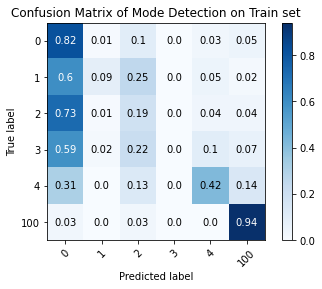

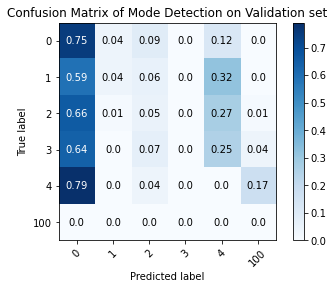

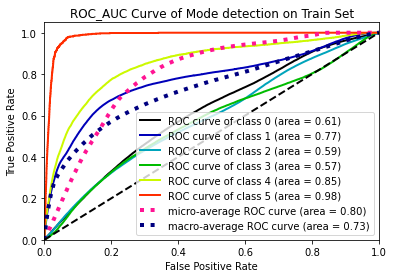

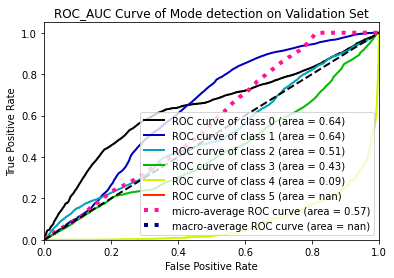

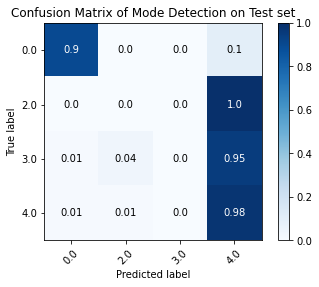

In [113]:
# from the model_2_basic_a
!nvidia-smi
PARAMS = {
    'Adam': False,
    'lr':0.095,
    'momentum':0.21,
    'batch_size': 13500,
    'epochs':40,
    'clipping': 1,
    # 'hidden_size': 64
    }

# run main_2()
try:
    main(train_dataset, val_dataset, test_dataset, PARAMS)
finally:
    neptune.stop()

# Optuna

In [29]:
def objective(trial):
    PARAMS = {'Adam': False, 
              'lr':trial.suggest_loguniform('lr', 1e-3, 1), 
        'momentum':trial.suggest_uniform('momentum', 0.0, 1.0),
        'batch_size': trial.suggest_int('batch_size', 32, 128, step=32),
        'epochs':trial.suggest_int('epochs', 10, 30, step=10,),
        'clipping':trial.suggest_int('clipping', 0.1, 1, step=0.25,),
        # 'hidden_size': trial.suggest_int('hidden_size', 10, 20, step = 5)
        }
    
    accuracy = main(train_dataset, val_dataset, test_dataset, PARAMS)
    
    return accuracy

In [30]:
! pip install --quiet optuna==2.3.0 lightgbm==3.1.0 plotly==4.13.0 neptune-client==0.4.132 neptune-contrib[monitoring]==0.25.0
import neptunecontrib.monitoring.optuna as opt_utils
neptune.create_experiment('optuna-sweep')
neptune_callback = opt_utils.NeptuneCallback(log_study=True, log_charts=True)
import optuna
try: 
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100, callbacks=[neptune_callback])
finally:
    neptune.stop()

NameError: name 'neptune' is not defined